# Magnetic levitation

- Code for large deformation magneto-elasticity of conducting solids. 

- Magnetic levitation of a circular plate specimen using an Axisymmetric formulation.

- Modeled after the benchmark "TEAM workshop Problem 28" (https://www.compumag.org/jsite/images/stories/TEAM/problem28.pdf)

- We use an axisymmetric coordinate system such that $\{\mathbf{e}_0, \mathbf{e}_1, \mathbf{e}_2\} = \{\mathbf{e}_r, \mathbf{e}_z, -\mathbf{e}_\theta \}$.

-  We use 3-D magnetic vector potential $\mathbf{a}_{\text{\tiny R}}$ as the magnetic degree of freedom, with 
$$\mathbf{b}_\text{\tiny R} = \text{Curl } \mathbf{a}_\text{\tiny R}.$$



### Units

- Basic:
    - Length: mm
    -   Time: s
    -   Mass: kg
    - Charge: C
    
- Derived: 
    - Force: mN
    - Pressure: kPa
    - Energy: $\mu\text{J}$
    - Current: A
    - Mag. flux density: T
    - Electrical conductivity: MS/mm, such that 1 MS/m = $10^{-3}$ MS/mm   


### Software:
- Dolfinx v0.9.0

Eric M. Stewart

stewaei@ucmail.uc.edu

Summer 2025


# Import modules

In [31]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile


# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TestFunction, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, sin, acos, ge, le, outer, tanh, cosh, atan, atan2)

# basix finite elements
import basix
from basix.ufl import element, mixed_element, quadrature_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime


# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [32]:
from dolfinx.io import gmshio

# Geometry parameters
radius = 65.0   # radius of plate, mm
scale = 300  # side length of air domain, mm

# Read in the 2D mesh and cell tags
with XDMFFile(MPI.COMM_WORLD,"meshes/TEAM28.xdmf",'r') as infile:
    domain = infile.read_mesh(name="Grid",xpath="/Xdmf/Domain")
    cell_tags = infile.read_meshtags(domain,name="Grid")
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

# Also read in 1D facets for applying BCs
with XDMFFile(MPI.COMM_WORLD,"meshes/facet_TEAM28.xdmf",'r') as infile:
    facet_tags = infile.read_meshtags(domain,name="Grid")
    
# A single point for "grounding" phi (on the plate)
def ground(x):
    return np.logical_and(np.isclose(x[0], 0), np.isclose(x[1], 3.8))
    # return  np.logical_and(np.isclose(x[1], 0), np.less_equal(x[0], radius))

x = ufl.SpatialCoordinate(domain)

**Print out the unique cell index numbers**

In [33]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[cell_tags.indices]=cell_tags.values # populating the array with facet tag index numbers
print(np.unique(cell_tags.values))          # printing the unique indices

# Area domains: 
# 18 - Air
# 19 - Conducting plate
# 20 - Outer coil
# 21 - Inner coil

[18 19 20 21]


**Print out the unique facet index numbers**

In [34]:
top_imap = domain.topology.index_map(1)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

# Line domains: 
# 22 - Top
# 23 - Right
# 24 - Bottom
# 25 - Boundary of inner coil
# 26 - Boundary of outer coil
# 27 - Boundary of plate
# 28 - Left 

[27 28 29 30]


**Visualize reference configuration and boundary facets**

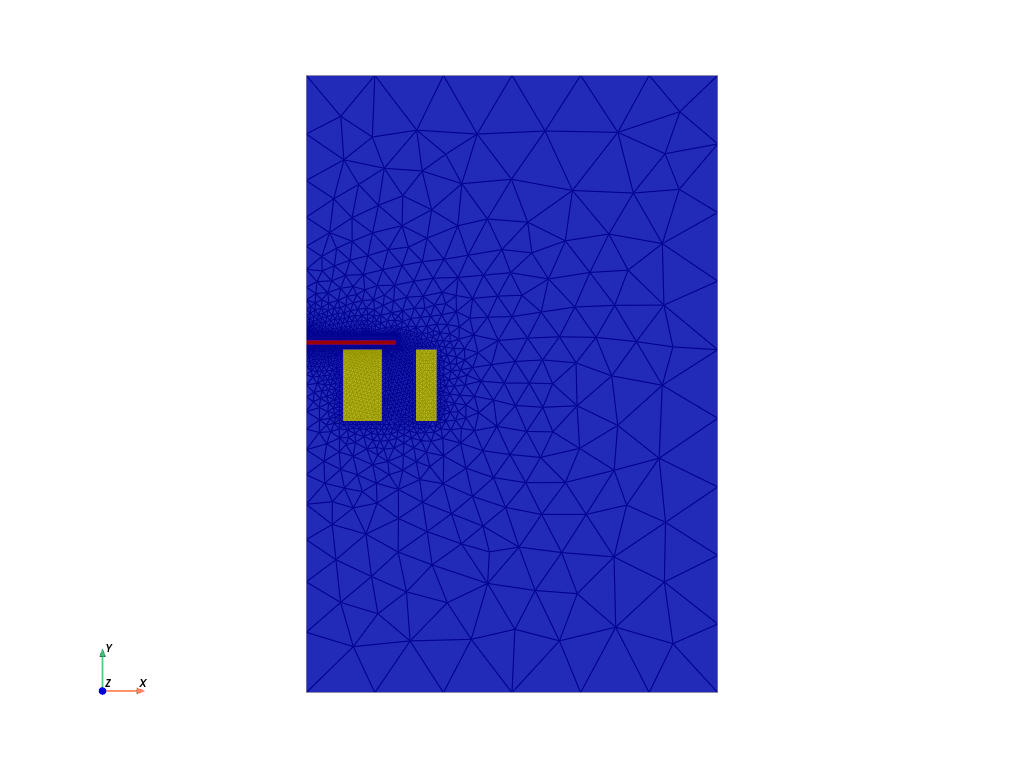

In [35]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
try:
    pyvista.start_xvfb()
except:
    pass

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True, opacity=0.25) 

# Add colored 1D surfaces for the named surfaces
plate_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==19]) )
coil1_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==20]) )
coil2_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==21]) )
air_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==18]) )
#
actor = plotter.add_mesh(plate_surf, show_edges=False,color="red") # mre is red
actor2 = plotter.add_mesh(air_surf, show_edges=False,color="blue") # air is blue
actor3 = plotter.add_mesh(coil1_surf, show_edges=False,color="yellow") # coils are yellow
actor4 = plotter.add_mesh(coil2_surf, show_edges=False,color="yellow") # coils are yellow

plotter.view_xy()

labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
plotter.add_axes(**labels)
    
plotter.screenshot("results/mesh.png")

from IPython.display import Image
Image(filename='results/mesh.png') 

## Define boundary and volume integration measure

In [36]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('dS', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':2})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, subdomain_data=cell_tags, metadata={'quadrature_degree': 2})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

#  Define facet normal
n2D = ufl.FacetNormal(domain)
n = ufl.as_vector([n2D[0], n2D[1], 0.0])

# Material parameters

In [37]:
# Building a function for constructing spatially varying (piecewise-constant) material parameters

# Need some extra infrastructure for the spatially-discontinuous material property fields
Vmat = functionspace(domain, ("DG", 0)) # create a DG0 function space on the domain

# A function to "safely" assign a value for properties, 
# accounting for syntax differences between FEniCSx v0.9.0 and v0.8.0. 
# This ensures that the code can be run using either version.
def safe_prop_assign(prop, i, val):
    try: # use the FEniCSx v0.9.0 syntax
        prop.x.petsc_vec.setValueLocal(i, val)
    except: # backup in case the user is running FEniCSx v0.8.0
        prop.vector.setValueLocal(i, val)

# the mat() function for spatially varying (piecewise-constant) material parameters
def mat(prop_val_plate, prop_val_air):

    # Define an empty "prop" material parameter function,
    # which lives on the DG0 function space.
    prop = Function(Vmat)
    
    # Now, actualy assign the desired values of the given material property to the new field.
    #
    coords = Vmat.tabulate_dof_coordinates()
    #
    # loop over the coordinates and assign the relevant material property, 
    # based on the local cell tag number.
    for i in range(coords.shape[0]):
        if cell_tags.values[i] == 19: 
            safe_prop_assign(prop, i, prop_val_plate)
        else:
            safe_prop_assign(prop, i, prop_val_air)
            
    return prop

In [38]:
# An air flag function, equal to 1 in the air domain and 0 elsewhere
def air_flag():

    # Define an empty "prop" material parameter function,
    # which lives on the DG0 function space.
    prop = Function(Vmat)
    
    # Now, actualy assign the desired values of the given material property to the new field.
    #
    coords = Vmat.tabulate_dof_coordinates()
    #
    # loop over the coordinates and assign the relevant material property, 
    # based on the local cell tag number.
    for i in range(coords.shape[0]):
        if cell_tags.values[i] == 18: 
            safe_prop_assign(prop, i, 1.0)
        elif cell_tags.values[i] == 20:
            safe_prop_assign(prop, i, 0.5)
        elif cell_tags.values[i] == 21:
            safe_prop_assign(prop, i, 0.5) 
        else:
            safe_prop_assign(prop, i, 0.0)
            
    return prop

In [39]:
# Elasticity parameters
Eyoung = 69.0e6 # Young's modulus, kPa
anu = 0.3 # Poisson's ratio
Gshear   = mat(Eyoung/(2.0*(1.0+anu)), 1.0e-3) # Shear modulus, kPa
Kbulk    = mat(Eyoung/(3.0*(1.0-2.0*anu)), 1.0e-5) # Bulk modulus, kPa

# Mass density
rho =  mat(2.6875e-6, 0.0)  # 2.7e3 kg/m^3 = 2.7e-6 kg/mm^3

# Magnetization parameters 
#
# Vacuum permeability
mu0 = Constant(domain, 1.256e-6*1e3) # Vacuum permeability,  mN / mA^2
#
# material permeability (paramagnetic response)
chi = mat(0.0, 0.0)# unitless magnetic susceptibility
mu  = mu0*(1.0 + chi) # magnetic permeability

# Conductivity values
sigma = mat(34.0e-3, 1.0e-13)   # 1/(muOhm mm) (Al, air). Recall 1 MS/m = 1e-3 1/(muOhm mm)

# flag for whether the domain is the air or not
TairInd   = air_flag()

# Generalized-alpha method parameters
alpha   = Constant(domain, 0.0) # Set \alpha=0, since we observe no spurious pressure oscillations
gamma   = Constant(domain, PETSc.ScalarType(0.5+alpha))
beta    = Constant(domain, PETSc.ScalarType((gamma+0.5)**2/4.))

# Simulation time-control related params

In [40]:
# Simulation time control-related params
t    = 0.0         # start time (s)
#
freq = 50 # Hz
period = 1.0/freq
numSteps = 100 
dt = 0.5e-3
#
# dt   = Constant(domain, PETSc.ScalarType(dtSize) ) #period/numSteps))       # (fixed) initial step size
#
numCycles = 1.0
Ttot = 2.0 # numCycles*period        # total simulation time (s) 

# Compiler variable for time step
dk = Constant(domain, PETSc.ScalarType(dt))

# magnitude of current densities
js_mag_inner = -960*20/(28*52) # kA/mm^2 ( = 960 turns * 0.02 kA / (28 mm * 52 mm) )
js_mag_outer = 576*20/(15*52) # kA/mm^2 ( = 576 turns * 0.02 kA / (15 mm * 52 mm) )

# Boundary condition to ramp up current densities
def js_ramp(t):
    
    js_inner = js_mag_inner*float(sin(2.0*np.pi*freq*t))
    js_outer = js_mag_outer*float(sin(2.0*np.pi*freq*t))
    
    return js_inner, js_outer



In [41]:
# A function for applying spatially varying (piecewise-constant) source currents
# This is essentially the same approach used for the spatially-varying material parameters.
#
# Area domains: 
# 18 - Air
# 19 - Conducting plate
# 20 - Outer coil
# 21 - Inner coil

def build_js_dist(inner_coil_val, outer_coil_val):

    # Define an empty "prop" material parameter function,
    # which lives on the DG0 function space.
    prop = Function(Vmat)
    
    # Now, actualy assign the desired values of source current density to the new field.
    #
    coords = Vmat.tabulate_dof_coordinates()
    #
    # loop over the coordinates and assign the relevant material property, 
    # based on the local cell tag number.
    for i in range(coords.shape[0]):
        if cell_tags.values[i] == 20: 
            safe_prop_assign(prop, i, outer_coil_val)
        elif cell_tags.values[i] == 21:
            safe_prop_assign(prop, i, inner_coil_val)
        else: 
            safe_prop_assign(prop, i, 0.0)
            
    return prop

In [42]:
# initialize the current source distribution
js_inner = Constant(domain, PETSc.ScalarType(js_mag_inner/200)) 
js_outer = Constant(domain, PETSc.ScalarType(js_mag_outer/200)) 
j_s = build_js_dist(js_inner, js_outer)

# Function spaces

In [43]:

U2 = element("Lagrange", domain.basix_cell(), 1, shape=(2,))  # For displacement
# U2a = element("Lagrange", domain.basix_cell(), 2, shape=(3,))  # For vector potential
U2a = element("Lagrange", domain.basix_cell(), 1)
P1 = element("Lagrange", domain.basix_cell(), 1)  # For phi
#
TH = mixed_element([U2, U2a])     # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs
#
V1 = functionspace(domain, P1) # Scalar function space.
V2 = functionspace(domain, U2) # (2d) Vector function space
V2a = functionspace(domain, U2a) # (3d) Vector function space

# Define actual functions with the required DOFs
w = Function(ME)
u, a_z = split(w)  # displacement u, pressure p, chemical potential mu, and concentration c

# A copy of functions to store values in the previous step for time-stepping
w_old = Function(ME)
u_old, a_z_old  = split(w_old)   
#
w_old2 = Function(ME)
u_old2, a_z_old2 = split(w_old2)

# Define test functions    
u_test, a_z_test = TestFunctions(ME)  

v_old = Function(V2)
acc_old = Function(V2)

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)   

a = ufl.as_vector([0, 0, a_z])
a_old = ufl.as_vector([0, 0, a_z_old])
a_old2 = ufl.as_vector([0*a_z_old2, 0*a_z_old2, a_z_old2])
a_test = ufl.as_vector([0*a_z_test, 0*a_z_test, a_z_test])


# Initial conditions

- The initial conditions for degrees of freedom $\mathbf{a}$ and $\Phi$ are zero everywhere.
- These are imposed automatically, since we have not specified any non-zero initial conditions.

# Subroutines for kinematics and constitutive equations

Recall that we use an axisymmetric coordinate system such that $\{\mathbf{e}_0, \mathbf{e}_1, \mathbf{e}_2\} = \{\mathbf{e}_r, \mathbf{e}_z, -\mathbf{e}_\theta \}$.

Care must be taken in the construction of differential operators to respect this special coordinate system.

In [44]:
#------------------------------------------------------------- 
# Utility subroutines
#-------------------------------------------------------------
 
# Subroutine for a "safer" sqrt() function which avoids a divide by zero 
# when automatically differentiated. 
def safe_sqrt(x):
    return sqrt(x + 1.0e-16)

#-------------------------------------------------------
# Subroutines for axisymmetry  
#-------------------------------------------------------

# Special gradient operators for axisymmetric functions 
#
# Gradient of vector field u   
def axi_grad_vector(u):
    
    grad_u = grad(u)
    
    axi_grad_33_exp = conditional(eq(x[0], 0), 0.0, u[0]/x[0])
    
    axi_grad_u = ufl.as_tensor([[grad_u[0,0], grad_u[0,1], 0],
                  [grad_u[1,0], grad_u[1,1], 0],
                  [0, 0, axi_grad_33_exp]]) 
    
    return axi_grad_u

# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
def axi_grad_scalar(y):
    
    grad_y = grad(y)
    
    axi_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.])
    
    return axi_grad_y

# Curl of vector field a
# (See, e.g., Appendix A of Anand and Govindjee, 2020)
def axi_curl_vector(a_):

    # Get the derivatives of a_
    grad_a = grad(a_)

    # cylindrical curl vector
    #
    ez_term = conditional(eq(x[0], 0), 0.0, a_[2]/x[0])
    #
    # Note: Since e_2 = - e_theta, the terms involving a[2] have an extra minus sign. 
    axi_curl_a = ufl.as_vector([grad_a[2,1], -grad_a[2,0] - ez_term, grad_a[0,1] - grad_a[1,0]])
    
    return axi_curl_a

# divergence of vector field a
# (See, e.g., Appendix A of Anand and Govindjee, 2020)
def axi_div_vector(a_):

    # cylindrical divergence value
    radial_term = conditional(eq(x[0], 0), 0.0, a_[0]/x[0])
    axi_div_a = 0.0 # a_[0].dx(0) + a_[1].dx(1) + radial_term
    
    return axi_div_a

# Axisymmetric deformation gradient 
def F_axi_calc(u):
    
    dim = len(u)                # dimension of problem (2)
    
    Id = Identity(dim)          # 2D Identity tensor
    
    F = Id + grad(u)            # 2D Deformation gradient
    
    F33_exp =  1.0 + u[0]/x[0]  # axisymmetric F33, R/R0 
    
    F33 = conditional(eq(x[0], 0.0), 1.0, F33_exp) # avoid divide by zero at r=0
      
    F_axi =  ufl.as_tensor([[F[0,0], F[0,1], 0],
                  [F[1,0], F[1,1], 0],
                  [0, 0, F33]]) # Full axisymmetric F
    
    return F_axi

# Subroutine for calculating the  equilibrium Cauchy stress
def T_eq_calc(u_):
    
    F   = F_axi_calc(u_)
    
    J = det(F)
    
    Fbar = J**(-1/3)*F
    
    Bbar = Fbar*Fbar.T
    
    T_eq = (1/J)* Gshear * dev(Bbar) + Kbulk * (J-1.0) * Identity(3)
    
    return T_eq


def Piola_calc(u_, a_):
    
    F = F_axi_calc(u_)
    
    J = det(F)
    
    T_eq = T_eq_calc(u_)
    
    T = T_eq 
    
    Piola = J * T * inv(F.T)
    
    return  Piola


#---------------------------------------------------------------------
# Subroutine for updating  acceleration using the Newmark beta method:
# a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
#---------------------------------------------------------------------
def update_a(u, u_old, v_old, a_old):
    return (u-u_old-dk*v_old)/beta/dk**2 - (1-2*beta)/2/beta*a_old

#---------------------------------------------------------------------
# Subroutine for updating  velocity using the Newmark beta method
# v = dt * ((1-gamma)*a0 + gamma*a) + v0
#---------------------------------------------------------------------
def update_v(a, u_old, v_old, a_old):
    return v_old + dk*((1-gamma)*a_old + gamma*a)

#---------------------------------------------------------------------
# alpha-method averaging function
#---------------------------------------------------------------------
def avg(x_old, x_new, alpha):
    return alpha*x_old + (1-alpha)*x_new


# Evaluate kinematics and constitutive relations

In [45]:
# Get acceleration and velocity at end of step
acc_new = update_a(u, u_old, v_old, acc_old)
v_new = update_v(acc_new, u_old, v_old, acc_old)

# get avg (u,p) fields for generalized-alpha method
u_avg  = avg(u_old, u, alpha)
a_avg  = avg(a_old, a, alpha)

# kinematical quantities
F  = F_axi_calc(u_avg)
J  = det(F)
C = F.T*F

# electromagnetic quantities
adot = (3*a_avg - 4*a_old + a_old2)/(2*dk)
calE = - adot
je   = J*sigma*ufl.inv(C)*calE
hR =  1.0/(mu*J)*C*axi_curl_vector(a_avg)

# Mechanical quantities
Piola =   Piola_calc(u_avg, a_avg)

# the Lorentz body force
lorentz = inv(F.T)*ufl.cross(je, axi_curl_vector(a_avg))

# Weak forms

In [46]:
g_grav = ufl.as_vector([0.0, -9.81e3])
lorentz_vec = ufl.as_vector([lorentz[0], lorentz[1]])

In [47]:
def Res_calc():
    
    Res_0  =  inner( Piola, axi_grad_vector(u_test))*x[0]*dx  \
          + inner(rho * acc_new, u_test)*x[0]*dx \
          - inner(rho * g_grav, u_test)*x[0]*dx(19)   \
         - inner(lorentz_vec, u_test)*x[0]*dx(19) 
   
    # Weak form of Ampere's Law
    Res_1 = inner( hR, axi_curl_vector(a_test) )*x[0]*dx \
           - inner( je, a_test )*x[0]*dx(19) \
           -  inner(ufl.as_vector([0.0, 0.0, j_s]), a_test )*x[0]*dx \
           + inner(  1.0/(float(mu0)*J) * axi_div_vector(a), axi_div_vector(a_test) )*x[0]*dx 

    return (1/(Eyoung))*Res_0 +  Res_1 

# Set-up output files

In [48]:
# results file name
results_name = "TEAM28_Axi_levitation"

# Function space for projection of results
P1 = element("DG", domain.basix_cell(), 1)
VV1 = fem.functionspace(domain, P1) # linear scalar function space
#
U1 = element("DG", domain.basix_cell(), 1, shape=(2,)) 
VV2 = fem.functionspace(domain, U1) # linear Vector function space
#
T1 = element("DG", domain.basix_cell(), 1, shape=(3,3)) 
VV3 = fem.functionspace(domain, T1) # linear tensor function space
#
U1a = element("DG", domain.basix_cell(), 1, shape=(3,)) 
VV2a = fem.functionspace(domain, U1a) # linear Vector function space


In [49]:
# For visualization purposes, we need to re-project the stress tensor onto a linear function space before 
# we write it (and its components and the von Mises stress, etc) to the VTX file. 
#
# This is because the stress is a complicated "mixed" function of the (quadratic Lagrangian) displacements
# and the (quadrature representation) plastic strain tensor and scalar equivalent plastic strain. 
#
# Create a linear problem for projecting the stress tensor onto the linear tensor function space VV3.

dx_proj = ufl.Measure('dx', domain=domain, subdomain_data=cell_tags, metadata={'quadrature_degree': 10})

def setup_projection(u, V):

    trial = ufl.TrialFunction(V)
    test  = ufl.TestFunction(V)  

   #  u_mod = conditional(gt(x[0], hmin), u, 0.0*u) 

    a_proj = ufl.inner(trial, test)*x[0]*dx
    L_proj = ufl.inner(u, test)*x[0]*dx(19)

    # air_dofs = fem.locate_dofs_topological(V, cell_tags.dim, cell_tags.find(11))
    # bcs = [dirichletbc(0.0, air_dofs, V) ] 

    projection_problem = dolfinx.fem.petsc.LinearProblem(a_proj, L_proj, [], \
       petsc_options={"ksp_type": "cg", "ksp_rtol": 1e-16, "ksp_atol": 1e-16, "ksp_max_it": 1000})
    
    return projection_problem



In [50]:
# primary fields to write to output file
u_vis      = Function(VV2, name="disp")
a_vis      = Function(VV1, name="a_R")

In [51]:
# Visualizing source currents 
js_vis  = Function(VV2a, name="js")

# Visualizing eddy currents
je_vis = Function(VV2a, name="je")
je_expr = Expression(F*je/J, VV2a.element.interpolation_points())

# Visualizing the power dissipation density
je_diss = dot(je, calE)
je_diss_vis = Function(VV1, name="je diss")
je_diss_expr = Expression(je_diss, VV1.element.interpolation_points())

# visualizing the magnetic b-field
b_vis = Function(VV2a, name="b_sp")
b_sp = F*axi_curl_vector(a)/J
b_expr = Expression(b_sp, VV2a.element.interpolation_points())

# Visualizing the (spatial) Lorentz force ( j x b ) term
je_sp = F*je/J
lorentz_sp = ufl.cross(je_sp, b_sp)
lorentz_sp_vec = ufl.as_vector([lorentz_sp[0], lorentz_sp[1]])
#
lorentz_proj = setup_projection(lorentz_sp_vec, VV2)
lorentz_temp = lorentz_proj.solve()
#
lorentz_vis = Function(VV2, name="Lorentz")
lorentz_expr = Expression(lorentz_temp, VV2.element.interpolation_points())


# visualizing adot
adot_vis = Function(VV2a, name="adot")
adot_expr = Expression(adot, VV2a.element.interpolation_points())

# visualizing the air domain flag
air_flag_vis = Function(VV1, name="Air_flag")
air_flag_expr = Expression(TairInd, VV1.element.interpolation_points())
air_flag_vis.interpolate(air_flag_expr)

In [52]:
# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, a_vis, js_vis, je_vis, b_vis, lorentz_vis, adot_vis, air_flag_vis,
    ],
    engine="BP4",
)

def writeResults(t):
    
    # Update the output fields before writing to VTX.
    #
    u_vis.interpolate(w.sub(0))
    a_vis.interpolate(w.sub(1))
    js_expr = Expression(ufl.as_vector([0.0, 0.0, j_s]), VV2a.element.interpolation_points())
    js_vis.interpolate(js_expr)
    je_vis.interpolate(je_expr)
    je_diss_vis.interpolate(je_diss_expr)
    b_vis.interpolate(b_expr)
    lorentz_temp = lorentz_proj.solve()
    lorentz_vis.interpolate(lorentz_expr)
    adot_vis.interpolate(adot_expr)
       
    # Finally, write output fields to VTX.
    #
    file_results.write(t) 

# Infrastructure for pulling out time history data (force, displacement, etc.)

In [53]:
# infrastructure for evaluating functions at a certain point efficiently
pointForEval = np.array([0.0, 3.8, 0.0])
bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForEval)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForEval).array

# computing the vertical Lorentz force on the plate
# here we need a factor of 2*pi*x[0] due to the integration over \theta
lorentz2          = dot(lorentz, ufl.as_vector([0,1,0]))
lorentz2_tot      = 2.0*np.pi*lorentz2*x[0]*dx(19)
lorentz2_tot_form = fem.form(lorentz2_tot) 

# computing the total eddy current in the plate section
# here we do not need the factor 2*pi*x[0] since we don't integrate wrt \theta, only r and z.
je_theta    = dot(je, ufl.as_vector([0,0,1]))
je_tot      = je_theta*dx(19)
je_tot_form = fem.form(je_tot) 

## Boundary condtions

In [ ]:
# Line domains: 
# 22 - Top
# 23 - Right
# 24 - Bottom
# 25 - Boundary of inner coil
# 26 - Boundary of outer coil
# 27 - Boundary of plate
# 28 - Left 

In [55]:

# Find the specific DOFs which will be constrained.
air_a_dofs   = fem.locate_dofs_topological((ME.sub(1), V2a), facet_tags.dim, facet_tags.find(29))
air_u_dofs   = fem.locate_dofs_topological((ME.sub(0), V2), facet_tags.dim, facet_tags.find(29))
#
coil_u_dofs   = fem.locate_dofs_topological((ME.sub(0), V2), facet_tags.dim, facet_tags.find(30))
#
left_a_dofs  = fem.locate_dofs_topological((ME.sub(1), V2a), facet_tags.dim, facet_tags.find(28))

# Zero displacement boundary conditions for the two fixed points
#
Vu_0, submap = ME.sub(0).collapse()
zero_u   = Function(Vu_0)
zero_u.interpolate(lambda x: np.stack(( np.zeros(x.shape[1]), np.zeros(x.shape[1]) ) ) )

# Zero displacement boundary conditions for the two fixed points
zero_a = Function(V2a)
zero_a.x.array[:] = 0.0  # Explicitly zero the vector values

# building Dirichlet BCs
bcs_0 = dirichletbc(zero_u, air_u_dofs, ME.sub(0)) # zero u - outer edge of domain
bcs_1 = dirichletbc(zero_a, air_a_dofs, ME.sub(1)) # zero a - outer edge of domain
bcs_2 = dirichletbc(zero_u, coil_u_dofs, ME.sub(0)) # zero u - coils
bcs_3 = dirichletbc(zero_a, left_a_dofs, ME.sub(1)) # zero a - left  edge of domain

bcs = [bcs_0, bcs_1, bcs_2, bcs_3]


## Define the nonlinear variational problem

In [56]:
# a function for re-building the solver when the j_s distribution is changed.
def build_problem():

    # Residual from weak forms
    Res = Res_calc( )

    # Automatic differentiation tangent:
    J_tan = derivative(Res, w, dw)

    # Set up nonlinear problem
    problem = NonlinearProblem(Res, w, bcs, J_tan)

    # the global newton solver and params
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-6
    solver.atol = 1e-6
    solver.max_it = 25

    return solver


##  Start calculation loop

In [57]:
# Give the step a descriptive name
step = "Actuate"

# Variables for storing time history
totSteps = 1000000
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps]) 
timeHist3 = np.zeros(shape=[totSteps]) 
timeHist4 = np.zeros(shape=[totSteps]) 

#Iinitialize a counter for reporting data
ii=0

#  Set up temporary "helper" functions and expressions 
#  for updating the velocity and acceleration.
v_temp = Function(V2)
acc_temp = Function(V2)
#
v_expr = Expression(v_new,V2.element.interpolation_points())
acc_expr = Expression(acc_new,V2.element.interpolation_points())

# Write initial state to file
writeResults(t=0.0)    

# print a message for simulation startup
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + float(dk), 9) <= Ttot):
     
    # increment time
    t += float(dk)
    
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    js_inner_val, js_outer_val = js_ramp(t-float(alpha*dk))
    js_inner.value = float(js_inner_val)
    js_outer.value = float(js_outer_val)
    #
    j_s = build_js_dist(js_inner, js_outer)

    # re-build the problem with updated j_s
    #
    # (when j_s is updated, the weak forms are updated and not merely the BCs.
    #  This means the problem and the associated solver must be re-built.)
    solver = build_problem()
    
    # Solve the problem
    (iter, converged) = solver.solve(w) 
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Print progress of calculation periodically
    if ii%1 == 0:      
      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print("Step: {} |   Increment: {} | Iterations: {}".format(step, ii, iter))
      print("dt: {} s | Simulation Time: {} s  of  {} s".format(round(float(dk), 4), round(t,4), Ttot))
      print()   
      
    # Write output to file
    writeResults(t)
       
    # Store time history variables at this time  
    timeHist0[ii] = t # current time 
    #
    timeHist1[ii] = float(js_inner_val)*(28*52) # time history of applied current
    #
    timeHist2[ii] = w.sub(0).sub(1).eval([0, 3.8, 0], colliding_cells[0])[0]  # time history of b-field
    #
    timeHist3[ii] = domain.comm.gather(fem.assemble_scalar(lorentz2_tot_form))[0] 
    #
    timeHist4[ii] = domain.comm.gather(fem.assemble_scalar(je_tot_form))[0] 
    
    # interpolate the values of the internal variables into their "temp" functions
    v_temp.interpolate(v_expr)
    acc_temp.interpolate(acc_expr)
    #
    # Update DOFs for next step
    w_old2.x.array[:] = w_old.x.array
    w_old.x.array[:] = w.x.array
    #
    v_old.x.array[:] = v_temp.x.array[:]
    acc_old.x.array[:] = acc_temp.x.array[:]
    
# close the output file.
file_results.close()
# xdmf.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Actuate |   Increment: 1 | Iterations: 3
dt: 0.0005 s | Simulation Time: 0.0005 s  of  2.0 s

Step: Actuate |   Increment: 2 | Iterations: 3
dt: 0.0005 s | Simulation Time: 0.001 s  of  2.0 s

Step: Actuate |   Increment: 3 | Iterations: 3
dt: 0.0005 s | Simulation Time: 0.0015 s  of  2.0 s

Step: Actuate |   Increment: 4 | Iterations: 3
dt: 0.0005 s | Simulation Time: 0.002 s  of  2.0 s

Step: Actuate |   Increment: 5 | Iterations: 3
dt: 0.0005 s | Simulation Time: 0.0025 s  of  2.0 s

Step: Actuate |   Increment: 6 | Iterations: 3
dt: 0.0005 s | Simulation Time: 0.003 s  of  2.0 s

Step: Actuate |   Increment: 7 | Iterations: 3
dt: 0.0005 s | Simulation Time: 0.0035 s  of  2.0 s

Step: Actuate |   Increment: 8 | Iterations: 3
dt: 0.0005 s | Simulation Time: 0.004 s  of  2.0 s

Step: Actuate |   Increment: 9 | Iterations: 3
dt: 0.0005 s | Simulation Time: 0.0045 s  of  2.0 s

Step: Actuate

# Plot results

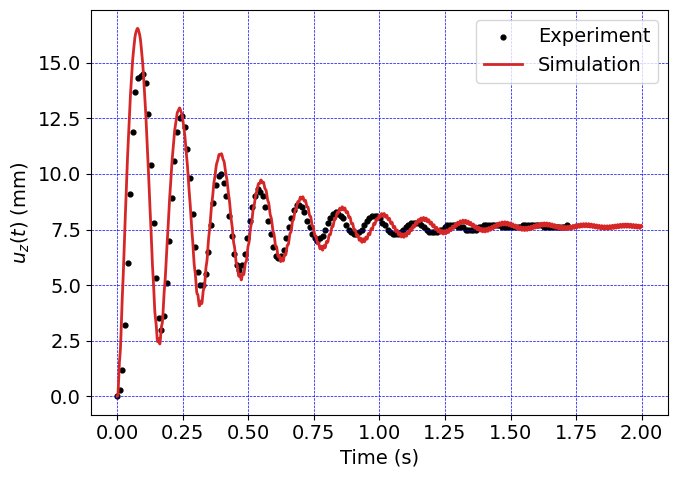

In [59]:
# Set plot font to size 14
font = {'size'   : 14}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

expData = np.genfromtxt('results/levitation_height.csv', delimiter=',')

# Only plot as far as we have time history data
ind = np.argmax(timeHist0) +1

plt.figure()
plt.scatter((expData[:,0] - expData[1,0])/1e3, expData[:,1] - expData[1,1], s=12,
                     edgecolors= (0.0, 0.0, 0.0,1),
                     color=(0,0,0,1),
                     linewidth=1.0, label="Experiment")
# plt.axvline(0, c='k', linewidth=1.)
# plt.axhline(0, c='k', linewidth=1.)
plt.plot(timeHist0[0:ind], timeHist2[0:ind], linewidth=2.0, color=colors[3], label="Simulation")
plt.axis('tight')
plt.xlabel(r"Time (s)")
plt.ylabel(r"$u_z(t)$ (mm)")
plt.grid(linestyle="--", linewidth=0.5, color='b')
# plt.ylim(7.25,7.75)
# plt.xlim(1.9120,1.9130)
plt.legend()

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/levitation_curve.png", dpi=600)

<Figure size 640x480 with 0 Axes>

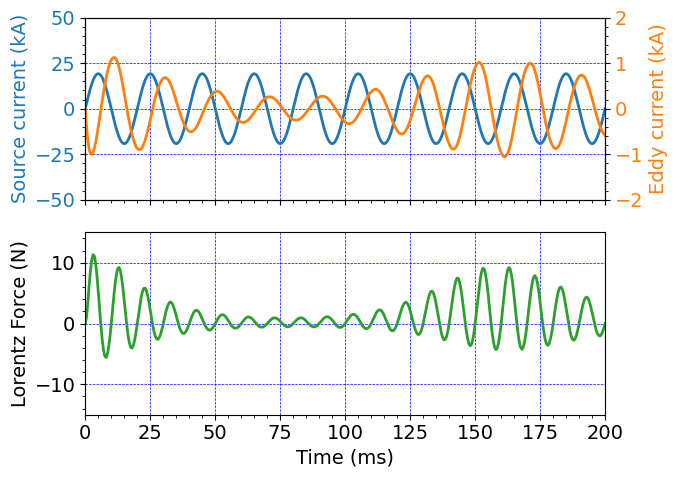

In [61]:
# Set plot font to size 14
font = {'size'   : 14}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

# expData = np.genfromtxt('results/levitation_height.csv', delimiter=',')

# Only plot as far as we have time history data
ind = np.argmax(timeHist0) +1

plt.figure()

# multi-plot figure
fig, (ax1, ax2) = plt.subplots(2,1, sharex='col')

ax1.plot(1e3*timeHist0[0:ind], -timeHist1[0:ind]/1e3, linewidth=2.0, color=colors[0])#,  label="Source current")
ax1.grid(linestyle="--", linewidth=0.5, color='b')
ax1.set_ylabel(r'Source current (kA)', color=colors[0])
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.set_ylim(-50,50)
ax1.tick_params(axis='y', labelcolor=colors[0])
# ax1.legend(loc='upper right')
#
ax1b = ax1.twinx()
ax1b.plot(1e3*timeHist0[0:ind], -timeHist4[0:ind]/1e3, linewidth=2.0, color=colors[1])#,  label="Eddy current")
ax1b.set_ylabel(r'Eddy current (kA)', color=colors[1])
ax1b.set_ylim(-2,2)
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax1b.xaxis.set_minor_locator(AutoMinorLocator())
ax1b.yaxis.set_minor_locator(AutoMinorLocator())
ax1b.tick_params(axis='y', labelcolor=colors[1])

ax2.plot(1e3*timeHist0[0:ind], timeHist3[0:ind]/1e3, linewidth=2.0, color=colors[2],  label="Lorentz")
ax2.grid(linestyle="--", linewidth=0.5, color='b')
ax2.set_ylabel(r'Lorentz Force (N)')
ax2.set_xlabel('Time (ms)')
ax2.set_ylim(-15, 15)
ax2.set_xlim(0, 10*period*1e3)
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/levitation_currents.png", dpi=600)

In [62]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

steps_per_cycle = int(period/dt/2)
lorentz_avg = moving_average(timeHist3[0:ind]/1e3, steps_per_cycle)

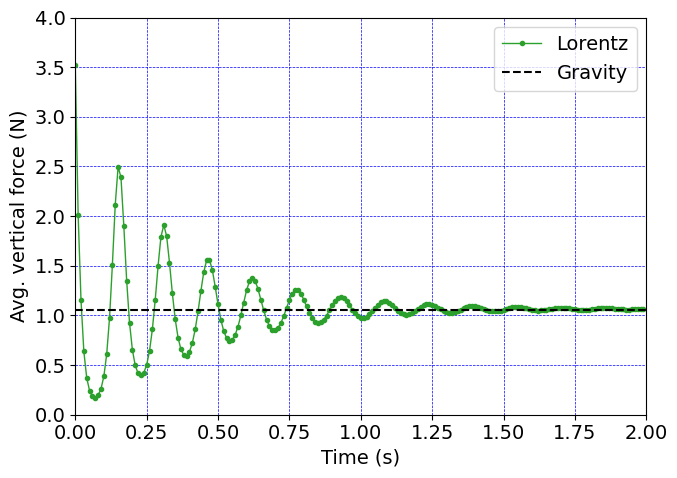

In [63]:
# Set plot font to size 14
font = {'size'   : 14}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

expData = np.genfromtxt('results/levitation_height.csv', delimiter=',')

# Only plot as far as we have time history data
ind = np.argmax(timeHist0) +1

plt.figure()
plt.plot(timeHist0[0:ind-steps_per_cycle:steps_per_cycle], lorentz_avg[0:ind-steps_per_cycle:steps_per_cycle], linewidth=1.0, marker='.', color=colors[2], label="Lorentz")
plt.axhline(0.107*9.81, c='k', linewidth=1.5, linestyle="--", label="Gravity")
plt.axis('tight')
plt.xlabel(r"Time (s)")
plt.ylabel(r"Avg. vertical force (N)")
plt.grid(linestyle="--", linewidth=0.5, color='b')
plt.ylim(0,4.0)
plt.xlim(0,Ttot)
plt.legend()

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/levitation_force.png", dpi=600)